# Machine Translation

English-German Translation

# 1)- Importing key modules

In [0]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [0]:
import string 
import re 
from numpy import array, argmax, random, take 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline 
pd.set_option('display.max_colwidth', 200)

In [3]:
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint 
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model 
from keras import optimizers 


Using TensorFlow backend.


# 2)- Reading Dataset

In [0]:
df= pd.read_pickle('full_data.pkl')

In [5]:
df.head(2)

,eng,ger
0,Prague Stock Market falls to minus by the end of the trading day,Die Prager Börse stürzt gegen Geschäftsschluss ins Minus.
1,After a sharp drop in the morning,Nach dem steilen Abfall am Morgen konnte die Prager Börse die Verluste korrigieren.


In [6]:
df.shape

(22191, 2)

In [0]:
df_random=df.sample(5000)

In [8]:
df_random.head(10)

,eng,ger
16424,He says Obama has had worthy efforts thwarted by GOP obstructionism,"Er sagt, Obama habe lobenswerte Bemühungen unternommen, die von der Blockadetaktik der Republikaner vereitelt worden seien"
19209,"A day after the school shooting forced students and faculty to hide behind locked doors, authorities were still trying to piece together what motivated Lamb.","Einen Tag nach der Schießerei in der Universität, die Studenten und Dozenten dazu zwang, sich hinter verschlossenen Türen zu verstecken, versuchen die Behörden immer noch, sich ein Bild davon zu v..."
9242,Rubbish bins set alight in Wedding,Müllcontainer im Wedding angezündet
12704,You have to pay extremely careful attention.,Man muss höllisch aufpassen
14086,"""This is not just a tax going into a black hole,"" said Adrian Moore, vice president of policy at Reason.","„Das ist keine Steuer, die in einem schwarzen Loch verschwindet“, erklärt Adrian Moore, Vizepräsident für Richtlinien bei Reason."
10663,Eurozone:,Eurozone:
6198,"O'Donovan bought the house with his sister four years ago for 380,000 Euros - financed with a 100 percent mortgage.",Gemeinsam mit einer Schwester hat O'Donovan das Haus für vor vier Jahren für 380.000 Euro gekauft - 100 Prozent kreditfinanziert.
681,In Germany,In Deutschland brachen die Preise noch stärker ein als in anderen europäischen Ländern:
1251,A siviglian dancer pays tribute to another siviglian dancer.,Eine Flamencotänzerin aus Sevilla verehrt eine Tänzerin
11182,"""It depends on the person's ability"" to accept the regression, he says.","""Das hängt von der Fähigkeit der Person ab"", einen Rückschritt hinzunehmen, stellt er fest."


In [0]:
deu_eng=df_random.values

In [10]:
type(deu_eng)

numpy.ndarray

In [11]:
deu_eng[0]

array(['He says Obama has had worthy efforts thwarted by GOP obstructionism',
       'Er sagt, Obama habe lobenswerte Bemühungen unternommen, die von der Blockadetaktik der Republikaner vereitelt worden seien'],
      dtype=object)

In [12]:
# for english part 
deu_eng[:,0]

array(['He says Obama has had worthy efforts thwarted by GOP obstructionism',
       'A day after the school shooting forced students and faculty to hide behind locked doors, authorities were still trying to piece together what motivated Lamb.',
       'Rubbish bins set alight in Wedding', ...,
       '11 are captured in Cadereyta',
       'Lamb did not provide an explanation for the shooting.',
       'Gravity no longer has any power over him'], dtype=object)

In [13]:
# for german part of lang.
deu_eng[:,1]

array(['Er sagt, Obama habe lobenswerte Bemühungen unternommen, die von der Blockadetaktik der Republikaner vereitelt worden seien',
       'Einen Tag nach der Schießerei in der Universität, die Studenten und Dozenten dazu zwang, sich hinter verschlossenen Türen zu verstecken, versuchen die Behörden immer noch, sich ein Bild davon zu verschaffen, was Lamb motivierte.',
       'Müllcontainer im Wedding angezündet', ...,
       '11 Personen in Cadereyta verhaftet',
       'Lamb gab keine Erklärung für seine Schüsse.',
       'Die Schwerkraft hat keine Macht mehr über ihn'], dtype=object)

# 3)-Text Pre-Processing

### 3.1)-Text cleaning

In [0]:
# Remove punctuation 
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]] 
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]] 

# convert text to lowercase 
for i in range(len(deu_eng)): 
    deu_eng[i,0] = deu_eng[i,0].lower() 
    deu_eng[i,1] = deu_eng[i,1].lower()

### 3.2)-Text to Sequence Conversion

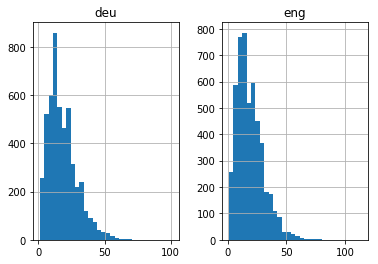

In [15]:
# empty lists 
eng_l = [] 
deu_l = [] 

# populate the lists with sentence lengths 
for i in deu_eng[:,0]: 
      eng_l.append(len(i.split())) 

for i in deu_eng[:,1]: 
      deu_l.append(len(i.split())) 

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})
length_df.hist(bins = 30) 
plt.show()

the maximum length of the German sentences is 78 and that of the English phrases is 75.

### 3.3)-vectorize our text data 

by using Keras’s Tokenizer()

In [16]:
# function to build a tokenizer 
def tokenization(lines): 
      tokenizer = Tokenizer() 
      tokenizer.fit_on_texts(lines) 
      return tokenizer

# prepare english tokenizer 
eng_tokenizer = tokenization(deu_eng[:, 0]) 
eng_vocab_size = len(eng_tokenizer.word_index) + 1 
eng_length = 8 

print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 14248


In [17]:
# prepare Deutch tokenizer 
deu_tokenizer = tokenization(deu_eng[:, 1]) 
deu_vocab_size = len(deu_tokenizer.word_index) + 1 
deu_length = 8 
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 20423


There is difference in amount of words in two languages.We need to encode sequence

### 3.4)-encode and pad sequences 

In [0]:
def encode_sequences(tokenizer, length, lines):          
         # integer encode sequences          
         seq = tokenizer.texts_to_sequences(lines)          
         # pad sequences with 0 values          
         seq = pad_sequences(seq, maxlen=length, padding='post')           
         return seq

# 4)-Model Building

### 4.1)- Train-test Split

80%-20%

In [0]:
from sklearn.model_selection import train_test_split 

# split data into train and test set 
train,test= train_test_split(deu_eng,test_size=0.2,random_state= 12)

### 4.2)- Defining input and target
We will encode English sentences as the input sequences and German sentences as the target sequences

In [20]:
# english version
train[:, 0]

array(['kenya has started biometrically registering all civil servants in an attempt to remove ghost workers from the governments payroll',
       'guests are also invited to take part in a tombola with impressive prizes and to sample some delicious food from the cafeteria',
       'i think we write very good songs and at the beginning was a great thing',
       ...,
       'scalia and thomas have shown little regard for critics who say they too readily mix the business of the court with agendadriven groups such as the federalist society',
       'i looked at sites blogs till someone responded offering me to go to begovaya station where a man will be waiting for me to take me to the corner so we can negotiate',
       'norbet bräms adds that on the level of its interventions in the public debt market the bce would have to make purchases of these bonds adequately large to revive the lacklustre market'],
      dtype=object)

In [21]:
# english version
train[:, 1]

array(['kenia hat damit begonnen alle staatsbeamten biometrisch zu registrieren um geisterangestellte aus den gehaltslisten der regierung zu löschen',
       'die gäste sind auch zu einer mit stattlichen sachpreisen bestückte tombola und zu einer lecker bestückten cafeteria eingeladen',
       'ich glaube wir haben sehr gute songs geschrieben und zu anfang war es großartig',
       ...,
       'scalia und thomas zeigen wenig rücksichtnahme auf kritiker die sagen sie würden gerichtsangelegenheit zu leicht mit gruppen die sich von der tagesordnung leiten lassen wie zum beispiel der föderalistischen gesellschaft vermischen',
       'ich hatte mir webseiten und blogs angesehen als jemand auf mich aufmerksam wurde und mir vorschlug zur station begowaja zu kommen wo eine person auf mich warten würde die mich an einen gewissen ort brächte wo wir dann den preis verhandeln könnten',
       'im bereich ihrer interventionen auf dem markt der staatsverschuldung sollte die ezb ein solches kaufvolum

In [0]:
# prepare training data 
trainX = encode_sequences(eng_tokenizer, deu_length, train[:, 0]) 
trainY = encode_sequences(deu_tokenizer, eng_length, train[:, 1]) 

# prepare validation data 
testX = encode_sequences(eng_tokenizer, deu_length, test[:, 0]) 
testY = encode_sequences(deu_tokenizer, eng_length, test[:, 1])

In [23]:
print(trainX[:5])

[[    3  2148  4242   458    22     1   793  3144]
 [    3 14037    73 14038   523    22     1 14039]
 [    6    21     1   462    13     5   182   721]
 [  267    85  6556   110  1860   677  2180  4341]
 [    1   153  1645    24    18    19  4714   186]]


In [24]:
print(trainY[:5])

[[ 6360    41     6 14753     2   105     8  6361]
 [ 4307     3     8    29 20033 20034 20035  3694]
 [ 2071  1567     3     8   643    45    18  3495]
 [   27     1   949   546    95  6939  1747  1748]
 [ 1156    16     1   259   708    21  4585    35]]


In [25]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(4000, 8)
(4000, 8)
(1000, 8)
(1000, 8)


### 4.3)- build NMT model

In [26]:
eng_length

8

In [27]:
deu_length

8

In [0]:
 def build_model(in_vocab,out_vocab, in_timesteps,out_timesteps,n):   
      model = Sequential() 
      model.add(Embedding(in_vocab, n, input_length=in_timesteps,   
      mask_zero=True)) 
      model.add(LSTM(n)) 
      model.add(RepeatVector(out_timesteps)) 
      model.add(LSTM(n, return_sequences=True))  
      model.add(Dense(out_vocab, activation='softmax')) 
      return model

In [29]:
# model compilation (with 512 hidden units)
model = build_model(eng_vocab_size,deu_vocab_size, eng_length, deu_length, 512)

rms = optimizers.RMSprop(lr=0.001) 
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 8, 512)            7294976   
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 8, 512)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 8, 512)            2099200   
_________________________________________________________________
dense_1 (Dense)              (None, 8, 20423)          10476999  
Total params: 21,970,375
Trainable params: 21,970,375
Non-trainable params: 0
_________________________________________________________________


In [31]:
filename = 'model_translate.h1' 

# set checkpoint
checkpoint = ModelCheckpoint(filename, monitor='val_loss',  
                             verbose=1, save_best_only=True, 
                             mode='min') 


# train model 
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
                    epochs=30, batch_size=512, validation_split = 0.2, 
                    callbacks=[checkpoint], verbose=1)


Train on 3200 samples, validate on 800 samples
Epoch 1/30
3200/3200 [==============================] - 6s 2ms/step - loss: 9.2255 - val_loss: 8.1206

Epoch 00001: val_loss improved from inf to 8.12055, saving model to model_translate.h1
Epoch 2/30
3200/3200 [==============================] - 3s 911us/step - loss: 7.7117 - val_loss: 8.2339

Epoch 00002: val_loss did not improve from 8.12055
Epoch 3/30
3200/3200 [==============================] - 3s 924us/step - loss: 7.5090 - val_loss: 8.3604

Epoch 00003: val_loss did not improve from 8.12055
Epoch 4/30
3200/3200 [==============================] - 3s 922us/step - loss: 7.4059 - val_loss: 8.4398

Epoch 00004: val_loss did not improve from 8.12055
Epoch 5/30
3200/3200 [==============================] - 3s 923us/step - loss: 7.3554 - val_loss: 8.5236

Epoch 00005: val_loss did not improve from 8.12055
Epoch 6/30
3200/3200 [==============================] - 3s 924us/step - loss: 7.4209 - val_loss: 8.6186

Epoch 00006: val_loss did not imp

# 5)-Plotting results

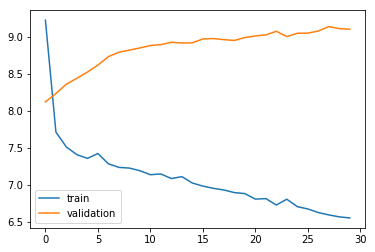

In [32]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.legend(['train','validation']) 
plt.show()

As you can see in the above plot, the validation loss stopped decreasing after 25 epochs. It did improve but not very significant.

# 6)-Make Predictions

In [0]:
model = load_model('model_translate.h1') 

preds = model.predict_classes(testX.reshape((testX.shape[0], testX.shape[1])))

These predictions are sequences of integers. We need to convert these integers to their corresponding words.

### 6.1)- Convert integers to words

In [0]:
def get_word(n, tokenizer):  
      for word, index in tokenizer.word_index.items():                       
          if index == n: 
              return word 
      return None

### 6.2)-Convert predictions into text (German)

In [0]:
preds_text = [] 
for i in preds:        
       temp = []        
       for j in range(len(i)):             
            t = get_word(i[j], deu_tokenizer)             
            if j > 0:                 
                if (t==get_word(i[j-1],deu_tokenizer))or(t== None):                       
                     temp.append('')                 
                else:                      
                     temp.append(t)             
            else:                    
                if(t == None):                                   
                     temp.append('')                    
                else:                           
                     temp.append(t)        
       preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'actual' : test[:,1], 'predicted' : preds_text})

In [37]:
# 1st 5 rows
pred_df.head(5)

,actual,predicted
0,roberto schulz meerbudenbesitzer und vorstandsmitglied bei der interessenvertretung der anlieger pro hieve klagt das wird ein riesenklotz der alle anderen gebaude überragt,
1,diese breite region ist beim menschen viel höher entwickelt als bei den übrigen primaten und scheint bei anderen geschöpfen gänzlich zu fehlen,
2,wenn von moderner nachkriegsarchitektur geschwärmt wird von klaren formen gläsernen hallen mutigen schwüngen und neuen baustoffen die typisch für den glauben an den technischen fortschritt sind da...,
3,der angeklagte bedauerte sein verhalten gestern,
4,mit der zeit resignierte darina ja es schien sogar als ob sie sich mit ihrem untreuen mann wieder versöhnen wolle nun aber gab sie ihm endgültig den laufpass,


In [38]:
# print 5 rows randomly 
pred_df.sample(5)

,actual,predicted
709,insgesamt konnte die allgemeine rücklage um rund 21 millionen euro auf jetzt insgesamt 49 millionen euro gesteigert werden,
867,john bradshaw experte für hundeverhalten und gaststipendiat an der fakultät für tierheilkunde der universität von bristol erklärte dies sei nicht die erste studie gewesen bei der untersucht wurde ...,
871,an die anwohner denken,
320,das von fujitsu bisher genutzte haus am rathausplatz und die benachbarte kleine vertikale gehörten mit den übrigen gebäuden am marienbader platz vor zehn jahren zu den umstrittensten bauvorhaben d...,
221,der erfolg der bildungsoffensive hielt sich in grenzen,
